In [109]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_validate
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from collections import OrderedDict

In [110]:
#leitura de arquivos e conversao de tipos
def read_file_convert(path):
    file = open(path, 'r')
    text = file.readlines()
    file.close()
    simulations_data = []
    val_data = []
    dic_data = {}
    for row in text[9:30]:
        simulations_data.append(row)
    for e in simulations_data:
        (key, val) = e.split(":")
        dic_data[str(key)] = val
    return dic_data

#limpeza dos dados retirando todos os caracteres diferentes de zeros
def remove_caracteres(dataset, name_col):
    result = []
    for value in dataset[name_col]:
        result.append(value.strip(' s\n\nbit/s\t%byteMbps'))
    dataset[name_col] = result

#faz a extracao de dados
def extraction_data(u, a, b, c, flag, cam):
    u += 1
    x = range(1,u)
    p1 = [a]
    p2 = [b]
    p3 = [c]
    data = []
    data_simulations = pd.DataFrame()
    
    for j in p2:
        for i in p1:
            for k in p3:
                for n in x:
                    s = cam+"{}-traces/step{}-packetInterval{}-packetSize{}/rodada{}/logMeshSimulation.txt".format(flag, j,i, k, n)
                    dataset = pd.DataFrame([read_file_convert(s)])
                    dataset['DistanceBetweenNode'] = j
                    dataset['PacketInterval'] = i
                    dataset['packetSize'] = k
                    data.append(dataset)
                data_simulations = pd.concat(data, ignore_index=True)
    return data_simulations

def transfor_columns(dataset):
    dataset.set_axis(['DeliveryRate',
                      'Throughput',
                      'TxBytes',
                      'RxBytes',
                      'TxPackets',
                      'RxPackets',
                      'LostPackets',
                      'DelaySum',
                      'DelayMean',
                      'JitterSum',
                      'JitterMean',
                      'TimeFirstTxPacket',
                      'TimeLastTxPacket',
                      'TimeFirstRxPacket',
                      'TimeLastRxPacket',
                      'MeanTransmittedPacketSize',
                      'MeanTransmittedBitrate',
                      'MeanHopCount',
                      'PacketLossRatio',
                      'MeanReceivedPacketSize',
                      'MeanReceivedBitrate',
                      'DistanceBetweenNode',
                      'PacketInterval',
                      'packetSize'], 
                       axis=1, inplace=True)
    return dataset

def clear_columns(dataset):
    remove_caracteres(dataset, 'DelayMean')
    remove_caracteres(dataset, 'DelaySum')
    remove_caracteres(dataset, 'DeliveryRate')
    remove_caracteres(dataset, 'JitterMean')
    remove_caracteres(dataset, 'JitterSum')
    remove_caracteres(dataset, 'TimeFirstRxPacket')
    remove_caracteres(dataset, 'TimeFirstTxPacket')
    remove_caracteres(dataset, 'TimeLastRxPacket')
    remove_caracteres(dataset, 'TimeLastTxPacket')
    remove_caracteres(dataset, 'LostPackets')
    remove_caracteres(dataset, 'MeanHopCount')
    remove_caracteres(dataset, 'MeanReceivedBitrate')
    remove_caracteres(dataset, 'MeanReceivedPacketSize')
    remove_caracteres(dataset, 'MeanTransmittedBitrate')
    remove_caracteres(dataset, 'MeanTransmittedPacketSize')
    remove_caracteres(dataset, 'PacketLossRatio')
    remove_caracteres(dataset, 'RxBytes')
    remove_caracteres(dataset, 'RxPackets')
    remove_caracteres(dataset, 'Throughput')
    remove_caracteres(dataset, 'TxBytes')
    remove_caracteres(dataset, 'TxPackets')

    return dataset

def selection_variables(dataset):
    data = OrderedDict(
    {
        'distanceBetweenNode': dataset['DistanceBetweenNode'],
        'packetInterval': dataset['PacketInterval'],
        'packetSize': dataset['packetSize'],
        'deliveryRate': dataset['DeliveryRate']
    })

    df = pd.DataFrame(data)

    df['distanceBetweenNode'] = df['distanceBetweenNode'].astype('int64')
    df['packetSize'] = df['packetSize'].astype('int64')
    df['packetInterval'] = df['packetInterval'].astype('float')
    df['deliveryRate'] = df['deliveryRate'].astype('float')

    return df

def create_dataset(u, a, b, c, flag, cam, i):
    dataset = extraction_data(u, a, b[i], c, flag, cam)
    dataset = clear_columns(transfor_columns(dataset))
    df = selection_variables(dataset)
    df2 = df.iloc[0, 0:3].values
    data = OrderedDict(
    {
        'distanceBetweenNode': df2[0],
        'packetInterval': df2[1],
        'packetSize': df2[2],
        'deliveryRate': sum(df.iloc[:,3].values)//df['deliveryRate'].count()
    })
    new_data_aux = pd.DataFrame(data, index=[i])
    return new_data_aux

def data_formulation(u, flag, cam, a, b, c):
    i = 1
    data_simulations = create_dataset(u, a, b, c, flag, cam, 0)
    while(i < len(b)):
        dataset_aux = create_dataset(u, a, b, c, flag, cam, i)
        data_simulations = pd.concat([data_simulations, dataset_aux])
        i += 1
    return data_simulations

In [111]:
def definitions_algorithms(name):
    if name == 'MLP':
        mlp_parameters = {'alpha':[0.1],
                          'activation':['logistic', 'tanh', 'relu'],
                          'learning_rate_init':[0.001],
                          'solver':['lbfgs'],
                          'hidden_layer_sizes':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
        return mlp_parameters
    if name == 'DT':
        dt_parameters = {'criterion':['mae','mse'],
                         'splitter':['best']}
        return dt_parameters
    if name == 'RF':
        rf_parameters = {'criterion':['mae','mse'],
                         'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
        return rf_parameters
    if name == 'SVR':
        svr_parameters = {'kernel':['poly', 'rbf'],
                          'gamma':[0, 10, 100],
                          'C':[1.0]}
        return svr_parameters
        
def optimize_parameters(reg, x, y, parameters):
    grid_search = GridSearchCV(reg, parameters, cv=2, refit=False)
    grid_search.fit(x, y)
    return grid_search.best_params_

#Cross-validation
def experiment_folds(st, reg, x, y):
    inter = range(1,31)
    scores = []
    errors = []
    models = {}
    mean_scores = []
    mean_errors = []

    for i in inter:
        kf = KFold(n_splits=5, random_state=i, shuffle=False)
        kf.get_n_splits(x)
        for train_index, test_index in kf.split(x):
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            reg.fit(x_train, y_train)
            scores.append(reg.score(x_test, y_test))
            rmse = np.sqrt(mean_squared_error(y_test, reg.predict(x_test)))
            errors.append(rmse)

        mean_scores.append(np.mean(scores))
        mean_errors.append(np.mean(errors))
    
    return np.mean(mean_scores), np.mean(mean_errors), reg

#Leave one out
def experiment_folds2(st, reg, x, y):
    inter = range(1,31)
    scores = []
    errors = []
    models = {}
    mean_scores = []
    mean_errors = []
    loo = LeaveOneOut()
    loo.get_n_splits(x)
    
    for train_index, test_index in loo.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        reg.fit(x_train, y_train)
        scores.append(reg.score(x_test, y_test))
        rmse = np.sqrt(mean_squared_error(y_test, reg.predict(x_test)))
        errors.append(rmse)
        
    mean_scores.append(np.mean(scores))
    mean_errors.append(np.mean(errors))
    
    return np.mean(mean_scores), np.mean(mean_errors), reg

def extraction_model(st, i, cam):
    filename = cam+'modelos/model_{}_{}.sav'.format(st, i)

    model = pickle.load(open(filename, 'rb'))
    return model

def interval_confidence(dataset):
    mean = np.mean(dataset)
    std = np.std(dataset)
    se = std/np.sqrt(len(dataset))
    v_critico = 0.95/2
    inter_confi = v_critico*se
    return inter_confi

def salve_model(st, model, cam):
    filename = cam+'modelos/model_{}.sav'.format(st)
    pickle.dump(model, open(filename, 'wb'))

In [112]:
def create_graphic(mod, med, set_test, simu, pred, predi, vali):
    plt.scatter(set_test, simu)
    plt.scatter(set_test, pred)
    plt.title('Simulação x Predição - Modelo: '+mod)
    plt.plot(vali[:,0], vali[:,1], color='blue')
    plt.plot(predi[:,0], predi[:,1], color='red')
    plt.legend(('Simulação', 'Predição'), loc='lower left')
    plt.xlabel('Principal componente')
    plt.ylabel(med)
    plt.savefig('result_'+mod+'.png')

In [113]:
#Resultados para a taxa de entrega
u = 30
flag = 1
cam = "C:/Users/joyce/Documents/joyce/dados-tcc/"
cam2 = "C:/Users/joyce/Documents/joyce/programsimulations/extraction_data/"

a = '0.01'
b = ['50', '60', '70', '80', '90', '95', '100']
c = '256'

data_simulations = data_formulation(u, flag, cam, a, b, c)
data_simulations

,distanceBetweenNode,packetInterval,packetSize,deliveryRate
0,50.0,0.01,256.0,100.0
1,60.0,0.01,256.0,100.0
2,70.0,0.01,256.0,100.0
3,80.0,0.01,256.0,100.0
4,90.0,0.01,256.0,100.0
5,95.0,0.01,256.0,99.0
6,100.0,0.01,256.0,93.0


In [114]:
# x representa o dataset de treino e possui 23 colunas sem o atributo alvo 
data_x = data_simulations.iloc[:, 0:3].values
# y representa o atributo alvo de x
data_y = data_simulations.iloc[:, 3:4].values

In [115]:
data_x

array([[5.00e+01, 1.00e-02, 2.56e+02],
       [6.00e+01, 1.00e-02, 2.56e+02],
       [7.00e+01, 1.00e-02, 2.56e+02],
       [8.00e+01, 1.00e-02, 2.56e+02],
       [9.00e+01, 1.00e-02, 2.56e+02],
       [9.50e+01, 1.00e-02, 2.56e+02],
       [1.00e+02, 1.00e-02, 2.56e+02]])

In [116]:
data_y

array([[100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [ 99.],
       [ 93.]])

In [117]:
random.seed(1)
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.2, random_state = 0)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape) 
print(y_test.shape)

(5, 3)
(5, 1)
(2, 3)
(2, 1)


In [118]:
# Escalonamento de dados
scaler_train_x = StandardScaler()
scaler_train_y = StandardScaler()
scaler_test_x = StandardScaler()
scaler_test_y = StandardScaler()

u = scaler_test_x.fit_transform(x_test)
x = scaler_train_x.fit_transform(x_train)
y = scaler_train_y.fit_transform(y_train)
v = scaler_test_y.fit_transform(y_test)

In [119]:
#Uso de PCA no conjunto de teste para exibicao dos resultados de forma grafica
pca = PCA(n_components=1)
set_test = pca.fit_transform(u)
set_test

array([[-1.],
       [ 1.]])

In [120]:
#Treinamento da MLP
mlp = optimize_parameters(MLPRegressor(), x, y, definitions_algorithms('MLP'))

mlp = MLPRegressor(alpha=mlp['alpha'],
                   activation=mlp['activation'], 
                   learning_rate_init=mlp['learning_rate_init'], 
                   solver=mlp['solver'], 
                   hidden_layer_sizes=mlp['hidden_layer_sizes'])

score, error, mlp = experiment_folds2('mlp', mlp, x, y)

print("Resultados após treinamento dos algoritmos")
print("Média do score -> ", score)
print("Média do erro -> ", error)
print("Modelo ->", mlp)

Resultados após treinamento dos algoritmos
Média do score ->  nan
Média do erro ->  0.9365370188064015
Modelo -> MLPRegressor(activation='tanh', alpha=0.1, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=80, learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)


In [121]:
#Carregamento do modelo
print("Valores da simulação - conjunto de validação -> \n", scaler_test_y.inverse_transform(v))
simu1 = sorted(scaler_test_y.inverse_transform(v))
print("Valores da predição - MLP -> \n", sorted(scaler_test_y.inverse_transform(mlp.predict(u))))
pred1 = sorted(scaler_test_y.inverse_transform(mlp.predict(u)))

Valores da simulação - conjunto de validação -> 
 [[ 93.]
 [100.]]
Valores da predição - MLP -> 
 [91.42162617119527, 98.50318920738184]


In [122]:
#Comparação entre valores da simulação e valores preditos - Taxa de entrega
vali = np.array(sorted([(x[0],y[0]) for x,y in zip(set_test, simu1)]))
predi1 = np.array(sorted([(x[0],y) for x,y in zip(set_test, pred1)]))

In [123]:
vali = np.array(sorted([(x[0],y[0]) for x,y in zip(set_test, simu1)]))
vali

array([[ -1.,  93.],
       [  1., 100.]])

In [124]:
vali[:,0]

array([-1.,  1.])

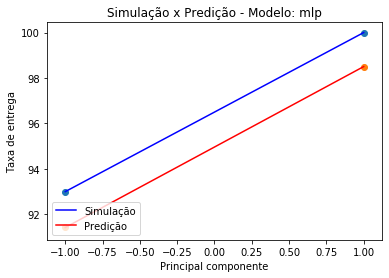

In [125]:
create_graphic('mlp', 'Taxa de entrega', set_test, simu1, pred1, predi1, vali)

In [126]:
scaler_train_x = StandardScaler()
scaler_train_y = StandardScaler()

x1 = scaler_train_x.fit_transform(data_x)
y1 = scaler_train_y.fit_transform(data_y)

In [127]:
x1

array([[-1.61107515,  0.        ,  0.        ],
       [-1.03274048,  0.        ,  0.        ],
       [-0.45440581,  0.        ,  0.        ],
       [ 0.12392886,  0.        ,  0.        ],
       [ 0.70226353,  0.        ,  0.        ],
       [ 0.99143086,  0.        ,  0.        ],
       [ 1.2805982 ,  0.        ,  0.        ]])

In [128]:
y1

array([[ 0.47304992],
       [ 0.47304992],
       [ 0.47304992],
       [ 0.47304992],
       [ 0.47304992],
       [ 0.05913124],
       [-2.42438082]])

In [129]:
#Uso de PCA no conjunto de teste para exibicao dos resultados de forma grafica
pca = PCA(n_components=1)
set_test = pca.fit_transform(x1)
set_test

array([[ 1.61107515],
       [ 1.03274048],
       [ 0.45440581],
       [-0.12392886],
       [-0.70226353],
       [-0.99143086],
       [-1.2805982 ]])

In [130]:
#Carregamento do modelo
print("Valores da simulação - conjunto de validação -> \n", scaler_train_y.inverse_transform(y1))
simu1 = sorted(scaler_train_y.inverse_transform(y1))
print("Valores da predição - MLP -> \n", sorted(scaler_train_y.inverse_transform(mlp.predict(x1))))
pred1 = sorted(scaler_train_y.inverse_transform(mlp.predict(x1)))

Valores da simulação - conjunto de validação -> 
 [[100.]
 [100.]
 [100.]
 [100.]
 [100.]
 [ 99.]
 [ 93.]]
Valores da predição - MLP -> 
 [93.79963575519143, 95.40856207875045, 97.38612372135324, 99.70630966178577, 100.17546853256486, 100.2410889163463, 100.2496834993268]


In [131]:
#Comparação entre valores da simulação e valores preditos - Taxa de entrega
vali = np.array(sorted([(x1[0],y1[0]) for x1,y1 in zip(set_test, simu1)]))
predi1 = np.array(sorted([(x1[0],y1) for x1,y1 in zip(set_test, pred1)]))

In [132]:
vali = np.array(sorted([(x1[0],y1[0]) for x1,y1 in zip(set_test, simu1)]))
vali

array([[ -1.2805982 , 100.        ],
       [ -0.99143086, 100.        ],
       [ -0.70226353, 100.        ],
       [ -0.12392886, 100.        ],
       [  0.45440581, 100.        ],
       [  1.03274048,  99.        ],
       [  1.61107515,  93.        ]])

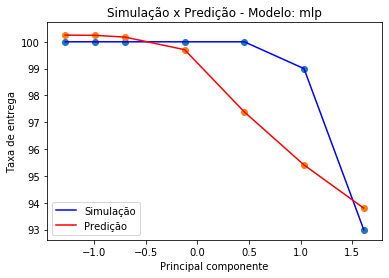

In [133]:
create_graphic('mlp', 'Taxa de entrega', set_test, simu1, pred1, predi1, vali)